<a href="https://colab.research.google.com/github/evaneigomes/Violacao-de-Dados-Modelos-Preditivos/blob/main/OrganizationType_Prophet_x_Arima_x_Xgboost_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Importar apenas o que será usado
import pandas as pd

# Carregar arquivo do Google Sheets
link_excel = "https://docs.google.com/spreadsheets/d/1NB3zRYOfdzZj-2KYTxNbsLd6Lx0knHEl/export?format=xlsx"
df_original = pd.read_excel(link_excel)


In [12]:
# ==========================================
# 📄 Cria uma cópia do DataFrame original
# ==========================================
# Fazemos a cópia para evitar alterar o df_original carregado do Excel.
df = df_original.copy()


# ==========================================
# 🗓️ Função para ajustar datas incompletas
# ==========================================
def ajustar_datas(data_str):
    """
    Ajusta valores de datas que podem vir incompletos:
    - 'YYYY'        → retorna NaT (ano sem mês/dia é descartado)
    - 'YYYY-MM'     → assume o dia 1 (primeiro dia do mês)
    - 'YYYY-MM-DD'  → mantém a data completa
    Retorna NaT se a conversão falhar.
    """
    try:
        if len(data_str) == 4:                         # Ex: '2005'
            return pd.NaT                               # Descarta apenas ano
        elif len(data_str) == 7:                        # Ex: '2005-09'
            return pd.Timestamp(data_str + '-01')      # Assume dia 1
        else:                                           # Ex: '2005-09-22'
            return pd.Timestamp(data_str)
    except:
        return pd.NaT                                   # Retorna vazio se falhar


# ==========================================
# ⏳ Ajuste e preparação da coluna de datas
# ==========================================
# Aplica a função à coluna de datas
df['Date Breach'] = df['Date Breach'].apply(ajustar_datas)

# Converte explicitamente para datetime (reforço)
df['Date Breach'] = pd.to_datetime(df['Date Breach'])

# Define a coluna 'Date Breach' como índice
df.set_index('Date Breach', inplace=True)

# Garante que o índice está no formato datetime
df.index = pd.to_datetime(df.index)


# ==========================================
# 🔎 Filtragem temporal (2010 a 2023)
# ==========================================
# Mantém somente registros entre 2010 e 2023
df = df[(df.index >= '2010-01-01') & (df.index < '2024-01-01')]


# ==========================================
# 📊 Reamostragem mensal inicial
# ==========================================
# Cria uma série temporal agregada mensalmente
serie = df.resample('ME').sum().fillna(0)

# Exibe 5 linhas aleatórias para conferência
print("📌 Amostra da série reamostrada:")
print(serie.sample(5))


# ==========================================
# 🧹 Limpeza adicional
# ==========================================
# Remove linhas com índice 'UNKN', caso existam
df = df[df.index != 'UNKN']

# Garante que o índice segue sendo datetime
df.index = pd.to_datetime(df.index)


# ==========================================
# 📂 Seleção de colunas relevantes
# ==========================================
cols = ['BSF', 'BSO', 'BSR', 'EDU', 'GOV', 'MED', 'NGO', 'Total Geral', 'UNKN']
df = df[cols].fillna(0)     # Mantém apenas as colunas necessárias e preenche nulos com 0


# ==========================================
# 📅 Reamostragem mensal final e filtro até 2024
# ==========================================
df_monthly = df.resample('ME').sum()
df_filtered = df_monthly[df_monthly.index <= '2024-12-31']


📌 Amostra da série reamostrada:
              BSF   BSO   BSR   EDU   GOV   MED   NGO   UNKN  Total Geral
Date Breach                                                              
2021-10-31   35.0  96.0  19.0  11.0  15.0  89.0  14.5  139.5        421.0
2013-08-31    3.0   7.0   2.0   5.0   1.0  14.0   1.0    8.0         41.0
2013-04-30    3.0  18.0   9.0   3.0   0.0  11.0   0.0   26.0         74.0
2020-01-31   17.0  59.0  17.0  13.0  11.0  41.0   5.0  106.5        272.0
2014-07-31    8.0   9.0  11.0   1.0   2.0  12.0   2.0   26.0         71.0


In [13]:
print(df.columns)
print("Número de linhas:", len(df))
total = df['Total Geral'].sum()
print("Total Geral:", total)


Index(['BSF', 'BSO', 'BSR', 'EDU', 'GOV', 'MED', 'NGO', 'Total Geral', 'UNKN'], dtype='object')
Número de linhas: 4124
Total Geral: 33706.5


/tmp/ipython-input-1843363311.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_mensal = df.resample("M").sum()


📈 Expoente de Hurst por setor:

BSF: H = 0.6265 → ↗ Tendência (H > 0.5)
BSO: H = 0.5275 → 📉 Comportamento aleatório (H ≈ 0.5)
BSR: H = 0.7371 → ↗ Tendência (H > 0.5)
EDU: H = 0.7395 → ↗ Tendência (H > 0.5)
GOV: H = 0.739 → ↗ Tendência (H > 0.5)
MED: H = 0.6511 → ↗ Tendência (H > 0.5)
NGO: H = 0.7233 → ↗ Tendência (H > 0.5)
Total Geral: H = 0.4456 → ↘ Reversão à média (H < 0.5)
UNKN: H = 0.542 → 📉 Comportamento aleatório (H ≈ 0.5)


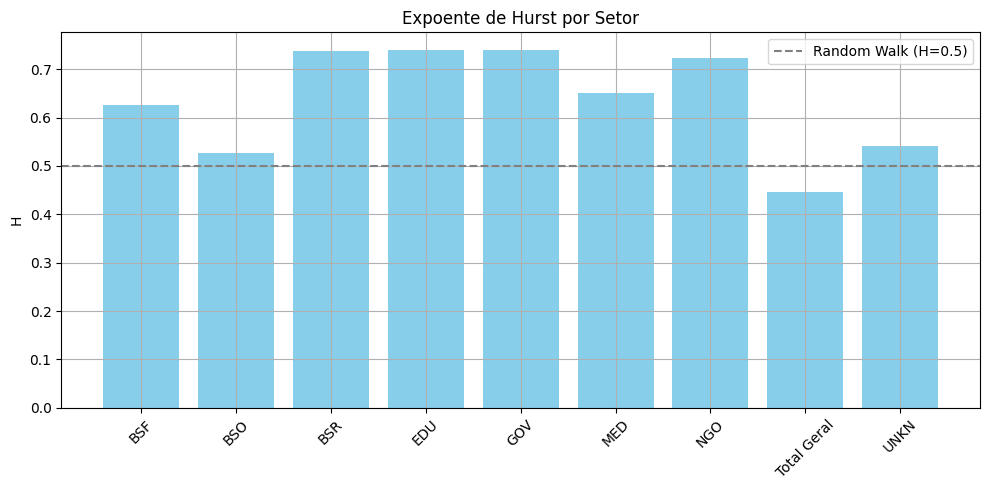

In [14]:
# ==========================================
# Instalação e Importações
# ==========================================
!pip install hurst --quiet
from hurst import compute_Hc
import matplotlib.pyplot as plt

# ==========================================
# Agrupamento mensal (índice já é datetime)
# ==========================================
df_mensal = df.resample("M").sum()

# ==========================================
# Cálculo do Expoente de Hurst por setor
# ==========================================
hurst_resultados = {}

for coluna in df_mensal.columns:
    serie = df_mensal[coluna].fillna(0).values
    if len(serie[serie > 0]) > 10:                 # precisa de dados suficientes
        H, _, _ = compute_Hc(serie, kind='change', simplified=True)
        hurst_resultados[coluna] = round(H, 4)

# ==========================================
# Exibição dos resultados
# ==========================================
print("📈 Expoente de Hurst por setor:\n")
for setor, hurst in hurst_resultados.items():
    if hurst < 0.5:
        interpretacao = "↘ Reversão à média (H < 0.5)"
    elif round(hurst, 1) == 0.5:
        interpretacao = "📉 Comportamento aleatório (H ≈ 0.5)"
    else:
        interpretacao = "↗ Tendência (H > 0.5)"
    print(f"{setor}: H = {hurst} → {interpretacao}")

# ==========================================
# Visualização Gráfica
# ==========================================
plt.figure(figsize=(10, 5))
plt.bar(hurst_resultados.keys(), hurst_resultados.values(), color='skyblue')
plt.axhline(0.5, color='gray', linestyle='--', label='Random Walk (H=0.5)')
plt.title("Expoente de Hurst por Setor")
plt.ylabel("H")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_gccki2n/ocdi64nm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_gccki2n/amyds5_b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43390', 'data', 'file=/tmp/tmp_gccki2n/ocdi64nm.json', 'init=/tmp/tmp_gccki2n/amyds5_b.json', 'output', 'file=/tmp/tmp_gccki2n/prophet_modeleqhd3g11/prophet_model-20250928091310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:13:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:13:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/


📊 Resultados para BSF
MAE:  13.21
RMSE: 15.37
MAPE: 39.47%
Melhores parâmetros: {'changepoint_prior_scale': 0.05, 'fourier_order': 15, 'n_changepoints': 50}


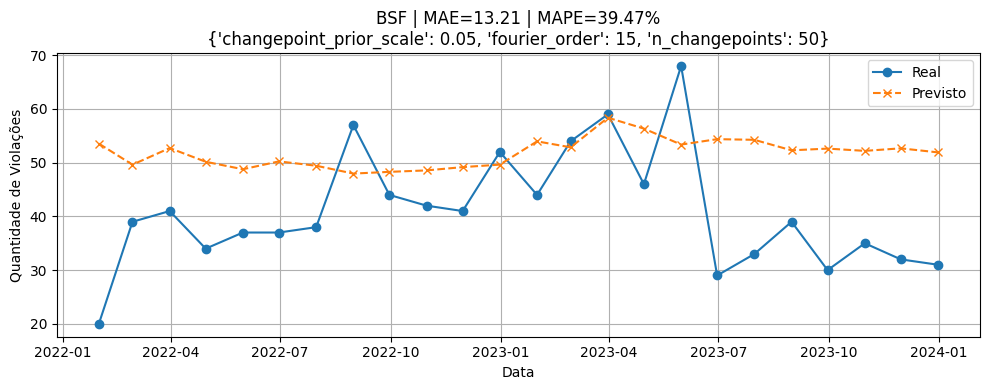

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_gccki2n/6sdky5ot.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_gccki2n/npyygyk4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12044', 'data', 'file=/tmp/tmp_gccki2n/6sdky5ot.json', 'init=/tmp/tmp_gccki2n/npyygyk4.json', 'output', 'file=/tmp/tmp_gccki2n/prophet_model5tqpguqa/prophet_model-20250928091314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:13:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:13:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/


📊 Resultados para BSO
MAE:  23.26
RMSE: 25.91
MAPE: 32.13%
Melhores parâmetros: {'changepoint_prior_scale': 0.05, 'fourier_order': 15, 'n_changepoints': 25}


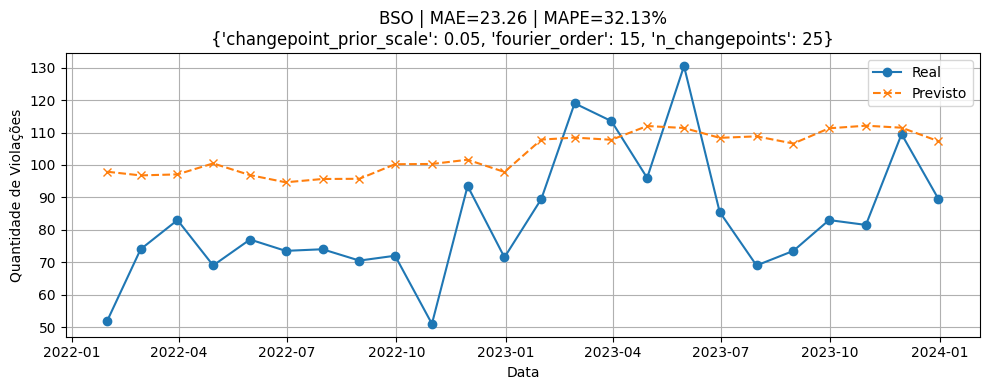

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_gccki2n/cgaxfc_z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_gccki2n/137wz8x5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91953', 'data', 'file=/tmp/tmp_gccki2n/cgaxfc_z.json', 'init=/tmp/tmp_gccki2n/137wz8x5.json', 'output', 'file=/tmp/tmp_gccki2n/prophet_modelsyp4vc_e/prophet_model-20250928091318.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:13:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:13:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/


📊 Resultados para BSR
MAE:  7.10
RMSE: 8.73
MAPE: 73.13%
Melhores parâmetros: {'changepoint_prior_scale': 0.1, 'fourier_order': 5, 'n_changepoints': 50}


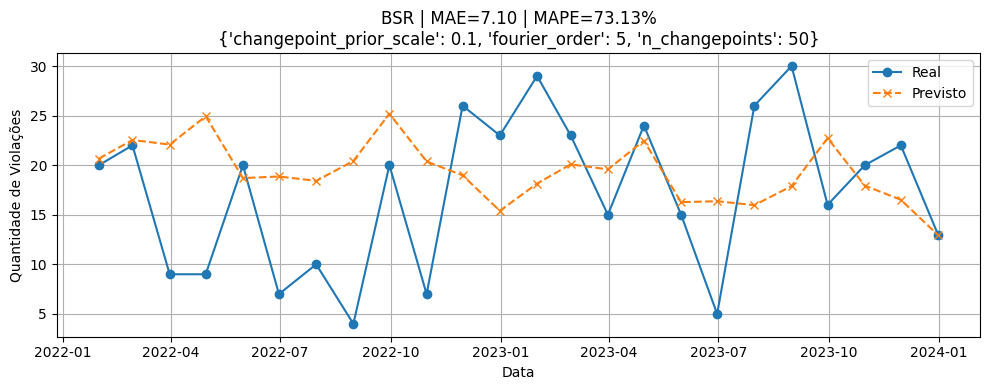

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_gccki2n/licbnrwl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_gccki2n/8f09s3fp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97704', 'data', 'file=/tmp/tmp_gccki2n/licbnrwl.json', 'init=/tmp/tmp_gccki2n/8f09s3fp.json', 'output', 'file=/tmp/tmp_gccki2n/prophet_modelepim5umo/prophet_model-20250928091322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:13:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:13:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/


📊 Resultados para EDU
MAE:  10.43
RMSE: 13.70
MAPE: 36.29%
Melhores parâmetros: {'changepoint_prior_scale': 0.1, 'fourier_order': 10, 'n_changepoints': 25}


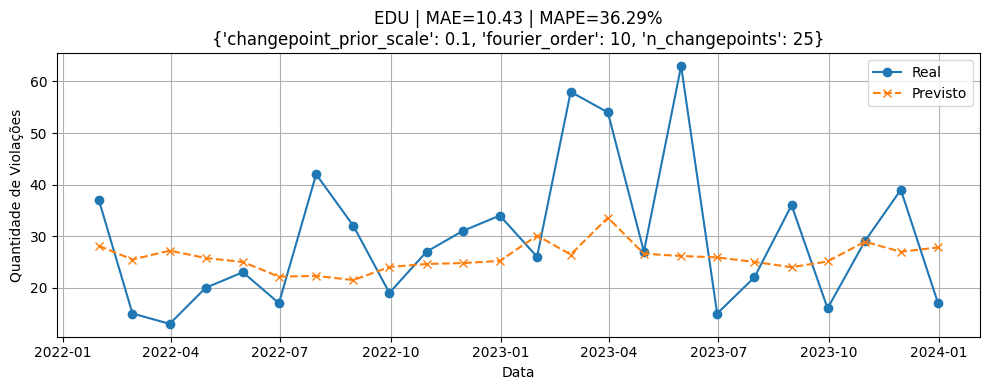

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_gccki2n/2xb6g9xp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_gccki2n/7fr8o_au.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47685', 'data', 'file=/tmp/tmp_gccki2n/2xb6g9xp.json', 'init=/tmp/tmp_gccki2n/7fr8o_au.json', 'output', 'file=/tmp/tmp_gccki2n/prophet_model7f5089er/prophet_model-20250928091326.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:13:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:13:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/


📊 Resultados para GOV
MAE:  4.00
RMSE: 5.39
MAPE: 40.17%
Melhores parâmetros: {'changepoint_prior_scale': 0.3, 'fourier_order': 5, 'n_changepoints': 50}


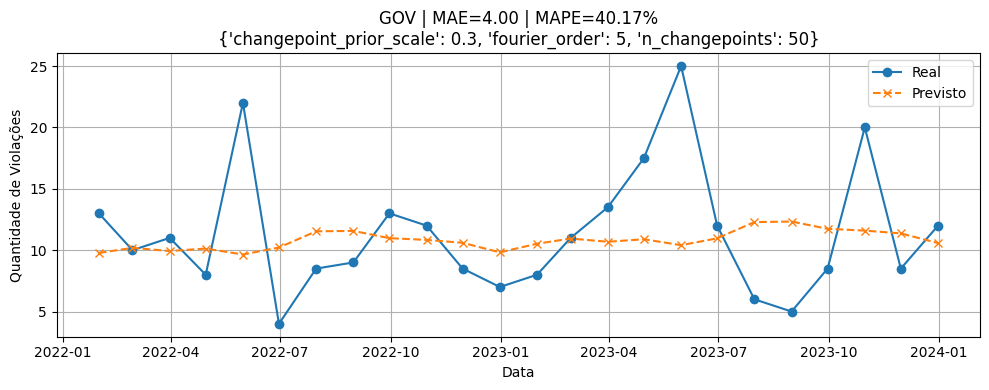

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_gccki2n/g2l3ynqd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_gccki2n/r_aa43d5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82519', 'data', 'file=/tmp/tmp_gccki2n/g2l3ynqd.json', 'init=/tmp/tmp_gccki2n/r_aa43d5.json', 'output', 'file=/tmp/tmp_gccki2n/prophet_model_rp307wo/prophet_model-20250928091331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:13:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:13:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/


📊 Resultados para MED
MAE:  15.53
RMSE: 18.20
MAPE: 26.54%
Melhores parâmetros: {'changepoint_prior_scale': 0.05, 'fourier_order': 15, 'n_changepoints': 50}


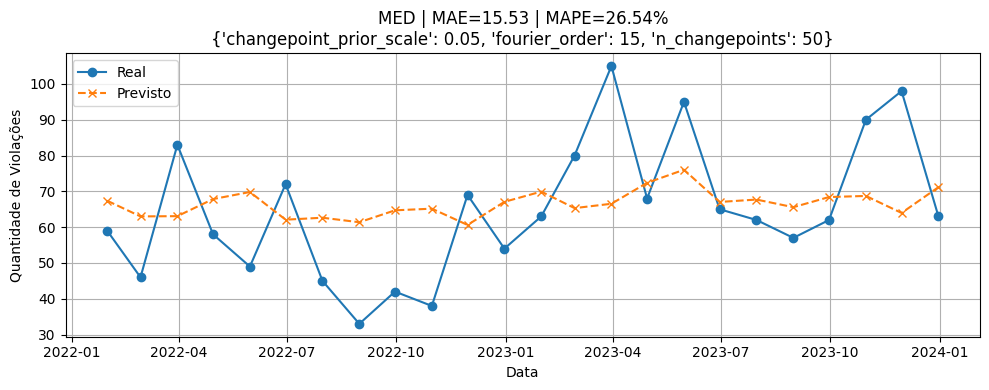

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_gccki2n/it7u8ryr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_gccki2n/9cjtw1tr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19105', 'data', 'file=/tmp/tmp_gccki2n/it7u8ryr.json', 'init=/tmp/tmp_gccki2n/9cjtw1tr.json', 'output', 'file=/tmp/tmp_gccki2n/prophet_modelnqap8rlr/prophet_model-20250928091336.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:13:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:13:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/


📊 Resultados para NGO
MAE:  5.42
RMSE: 6.08
MAPE: 48.75%
Melhores parâmetros: {'changepoint_prior_scale': 0.05, 'fourier_order': 5, 'n_changepoints': 50}


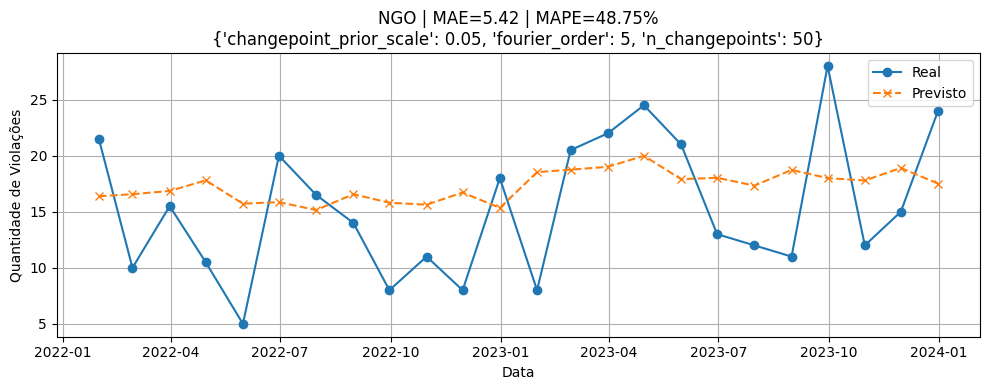

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_gccki2n/1npacolq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_gccki2n/nq918ir3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47210', 'data', 'file=/tmp/tmp_gccki2n/1npacolq.json', 'init=/tmp/tmp_gccki2n/nq918ir3.json', 'output', 'file=/tmp/tmp_gccki2n/prophet_model0kmi7u7j/prophet_model-20250928091340.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:13:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:13:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/


📊 Resultados para Total Geral
MAE:  61.73
RMSE: 69.66
MAPE: 17.63%
Melhores parâmetros: {'changepoint_prior_scale': 0.05, 'fourier_order': 15, 'n_changepoints': 25}


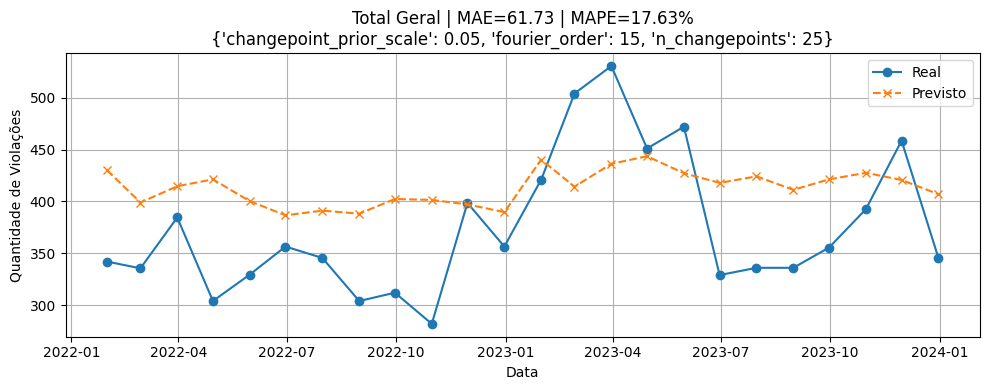

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_gccki2n/vtwlyj4e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_gccki2n/ifvygzga.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12464', 'data', 'file=/tmp/tmp_gccki2n/vtwlyj4e.json', 'init=/tmp/tmp_gccki2n/ifvygzga.json', 'output', 'file=/tmp/tmp_gccki2n/prophet_modeljb27x_n6/prophet_model-20250928091345.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:13:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:13:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.12/dist-packages/


📊 Resultados para UNKN
MAE:  21.41
RMSE: 24.87
MAPE: 22.54%
Melhores parâmetros: {'changepoint_prior_scale': 0.1, 'fourier_order': 15, 'n_changepoints': 50}


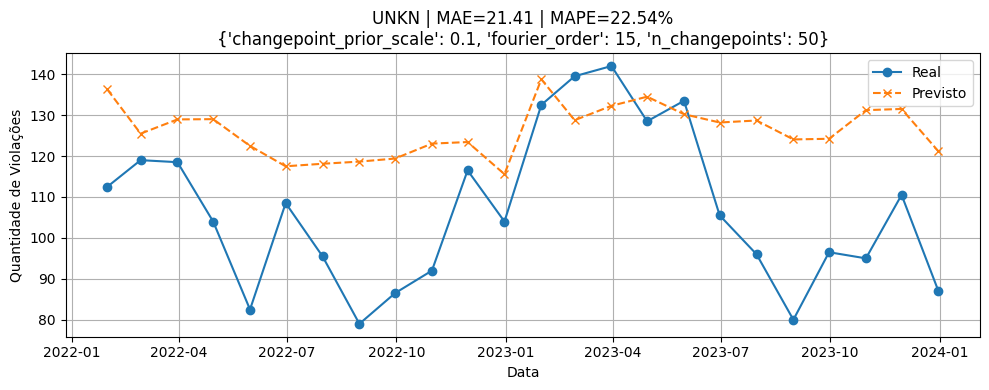


✅ Resultados Consolidados:
        Coluna    MAE   RMSE   MAPE  changepoint_prior_scale  fourier_order  \
0          BSF  13.21  15.37  39.47                     0.05             15   
1          BSO  23.26  25.91  32.13                     0.05             15   
2          BSR   7.10   8.73  73.13                     0.10              5   
3          EDU  10.43  13.70  36.29                     0.10             10   
4          GOV   4.00   5.39  40.17                     0.30              5   
5          MED  15.53  18.20  26.54                     0.05             15   
6          NGO   5.42   6.08  48.75                     0.05              5   
7  Total Geral  61.73  69.66  17.63                     0.05             15   
8         UNKN  21.41  24.87  22.54                     0.10             15   

   n_changepoints   Status  
0              50  Sucesso  
1              25  Sucesso  
2              50  Sucesso  
3              25  Sucesso  
4              50  Sucesso  
5      

In [16]:
# ==========================================
# 📦 Instalação de pacotes (somente no Colab)
# ==========================================
!pip install prophet openpyxl --quiet

# ==========================================
# 📦 Importações de Bibliotecas
# ==========================================
from prophet import Prophet                           # Modelo Prophet para previsão de séries temporais
import itertools                                      # Para criar combinações de parâmetros
import numpy as np                                    # Operações numéricas
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Métricas de avaliação
import matplotlib.pyplot as plt                       # Para gráficos
import pandas as pd                                    # Para manipulação de dados (se ainda não importado)

# ==========================================
# ⚙️ Definição do Grid Search
# ==========================================
changepoint_values = [0.05, 0.1, 0.3, 0.5]      # Controle da flexibilidade dos pontos de mudança
fourier_orders = [5, 10, 15]                    # Ordem da série de Fourier (captura sazonalidades)
n_changepoints_values = [25, 50]                # Número de pontos de mudança

# Cria todas as combinações possíveis de parâmetros
param_grid = list(itertools.product(
    changepoint_values,
    fourier_orders,
    n_changepoints_values
))

# Lista para armazenar os resultados de cada coluna
resultados_prophet = []

# ==========================================
# 📈 Função para aplicar Prophet em uma série
# ==========================================
def aplicar_prophet_serie(nome_coluna, df_series):
    """
    Aplica Prophet a uma série temporal:
    - Divide em treino (exceto últimas 24 observações) e teste (últimas 24)
    - Testa todas as combinações do grid search
    - Seleciona o melhor modelo (menor MAE)
    - Exibe gráfico comparando valores reais vs previstos
    - Armazena resultados na lista global
    """

    # Prepara DataFrame no formato exigido pelo Prophet
    df_temp = df_series[[nome_coluna]].copy()
    df_temp = df_temp.rename(columns={nome_coluna: 'y'})
    df_temp['ds'] = df_temp.index
    df_temp = df_temp[['ds', 'y']]

    # Divide em treino e teste
    train = df_temp[:-24]
    test = df_temp[-24:]

    # Variáveis para armazenar o melhor resultado
    best_model = None
    best_forecast = None
    best_metrics = {'mae': np.inf}
    best_params = None

    # ==========================================
    # 🔎 Loop de Grid Search
    # ==========================================
    for changepoint_prior_scale, fourier_order, n_changepoints in param_grid:
        try:
            # Configura e treina o modelo Prophet
            model = Prophet(
                yearly_seasonality=False,
                changepoint_prior_scale=changepoint_prior_scale,
                n_changepoints=n_changepoints
            )

            # Adiciona sazonalidade anual
            model.add_seasonality(
                name='anual',
                period=365.25,
                fourier_order=fourier_order
            )

            model.fit(train)

            # Gera previsões para os próximos 24 meses
            future = model.make_future_dataframe(periods=24, freq='M')
            forecast = model.predict(future)

            # Avaliação do modelo
            forecast_test = forecast.set_index('ds').loc[test['ds']]
            predicted = forecast_test['yhat'].values
            actual = test['y'].values

            mae = mean_absolute_error(actual, predicted)
            rmse = np.sqrt(mean_squared_error(actual, predicted))
            mape = np.mean(np.abs((actual - predicted) / actual)) * 100

            # Atualiza o melhor modelo
            if mae < best_metrics['mae']:
                best_model = model
                best_forecast = forecast
                best_metrics = {'mae': mae, 'rmse': rmse, 'mape': mape}
                best_params = {
                    'changepoint_prior_scale': changepoint_prior_scale,
                    'fourier_order': fourier_order,
                    'n_changepoints': n_changepoints
                }

        except Exception as e:
            print(f"⚠️ Erro em {nome_coluna} - params=({changepoint_prior_scale}, {fourier_order}, {n_changepoints}): {e}")
            continue

    # ==========================================
    # 🔎 Verifica se houve modelo válido
    # ==========================================
    if best_model is None:
        print(f"⚠️ Nenhum modelo válido para {nome_coluna}.")
        resultados_prophet.append({
            'Coluna': nome_coluna,
            'MAE': None,
            'RMSE': None,
            'MAPE': None,
            'changepoint_prior_scale': None,
            'fourier_order': None,
            'n_changepoints': None,
            'Status': 'Erro no ajuste'
        })
        return

    # ==========================================
    # 📊 Exibição do melhor resultado
    # ==========================================
    forecast_test = best_forecast.set_index('ds').loc[test['ds']]
    predicted = forecast_test['yhat'].values
    actual = test['y'].values

    print(f"\n📊 Resultados para {nome_coluna}")
    print(f"MAE:  {best_metrics['mae']:.2f}")
    print(f"RMSE: {best_metrics['rmse']:.2f}")
    print(f"MAPE: {best_metrics['mape']:.2f}%")
    print(f"Melhores parâmetros: {best_params}")

    # ==========================================
    # 📈 Gráfico Real vs Previsto
    # ==========================================
    plt.figure(figsize=(10, 4))
    plt.plot(test['ds'], actual, marker='o', label='Real')
    plt.plot(test['ds'], predicted, marker='x', linestyle='--', label='Previsto')
    plt.title(f"{nome_coluna} | MAE={best_metrics['mae']:.2f} | MAPE={best_metrics['mape']:.2f}%\n{best_params}")
    plt.xlabel('Data')
    plt.ylabel('Quantidade de Violações')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ==========================================
    # 📝 Armazena os resultados
    # ==========================================
    resultados_prophet.append({
        'Coluna': nome_coluna,
        'MAE': round(best_metrics['mae'], 2),
        'RMSE': round(best_metrics['rmse'], 2),
        'MAPE': round(best_metrics['mape'], 2),
        'changepoint_prior_scale': best_params['changepoint_prior_scale'],
        'fourier_order': best_params['fourier_order'],
        'n_changepoints': best_params['n_changepoints'],
        'Status': 'Sucesso'
    })

# ==========================================
# 🚀 Aplicação do Prophet para cada coluna
# ==========================================
for col in df_filtered.columns:
    if df_filtered[col].sum() > 0:           # Considera apenas séries com dados > 0
        aplicar_prophet_serie(col, df_filtered)

# ==========================================
# 💾 Consolidação e Exportação dos Resultados
# ==========================================
df_resultados_prophet = pd.DataFrame(resultados_prophet)
print("\n✅ Resultados Consolidados:")
print(df_resultados_prophet)

df_resultados_prophet.to_csv('resultados_prophet_gridsearch.csv', index=False)
print("\n💾 Resultados salvos em 'resultados_prophet_gridsearch.csv'")



🚩 Iniciando ARIMA para: BSF


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



📊 Resultados para BSF
MAE:  18.84
RMSE: 20.99
MAPE: 55.43%
Melhores parâmetros: Order=(0, 1, 1) | Seasonal=(0, 1, 1, 12) | AIC=824.61


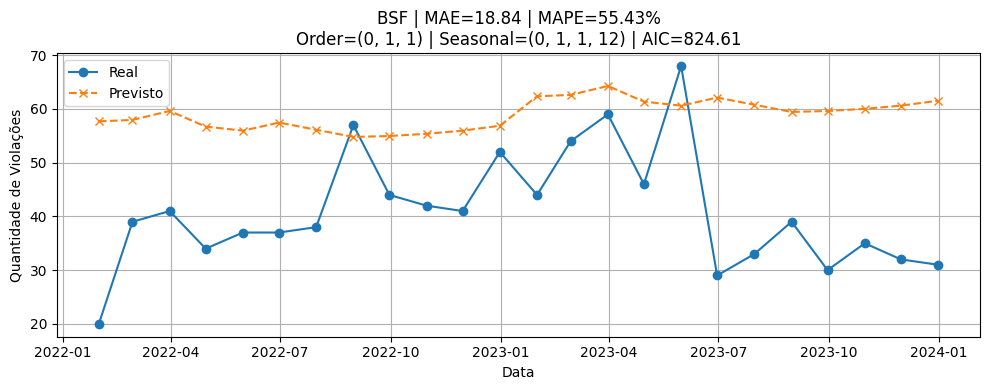


🚩 Iniciando ARIMA para: BSO

📊 Resultados para BSO
MAE:  25.12
RMSE: 27.89
MAPE: 34.77%
Melhores parâmetros: Order=(0, 1, 1) | Seasonal=(0, 1, 1, 12) | AIC=906.69


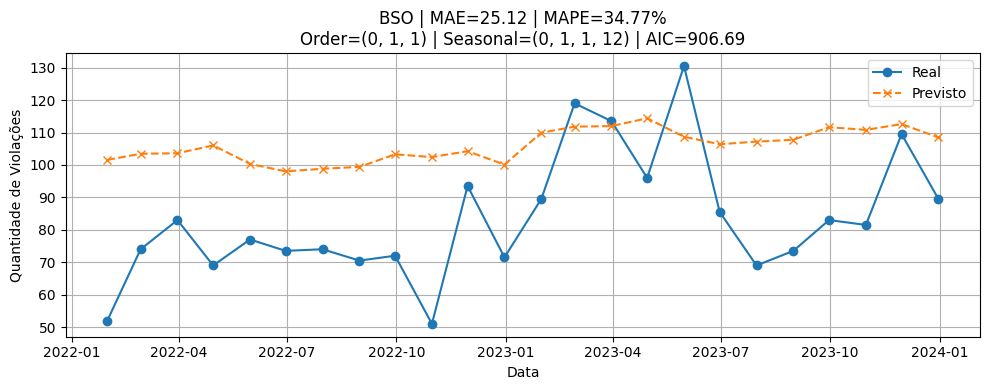


🚩 Iniciando ARIMA para: BSR

📊 Resultados para BSR
MAE:  7.52
RMSE: 9.35
MAPE: 80.64%
Melhores parâmetros: Order=(0, 1, 1) | Seasonal=(0, 1, 1, 12) | AIC=836.44


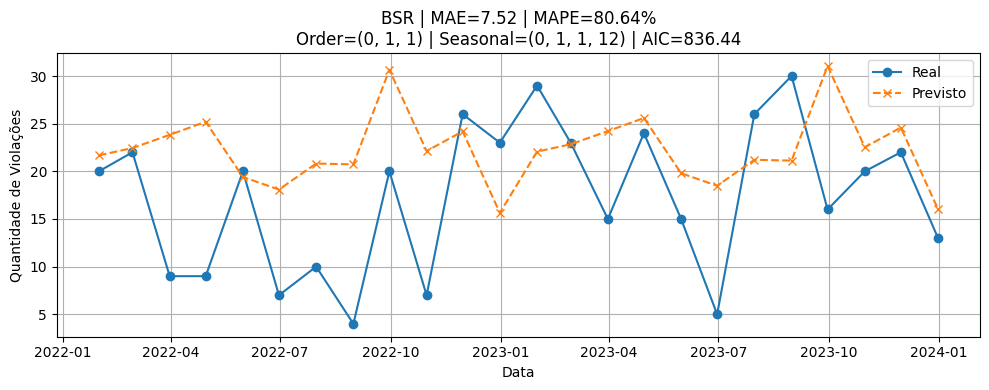


🚩 Iniciando ARIMA para: EDU


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



📊 Resultados para EDU
MAE:  10.76
RMSE: 13.82
MAPE: 36.74%
Melhores parâmetros: Order=(0, 1, 1) | Seasonal=(0, 1, 1, 12) | AIC=799.56


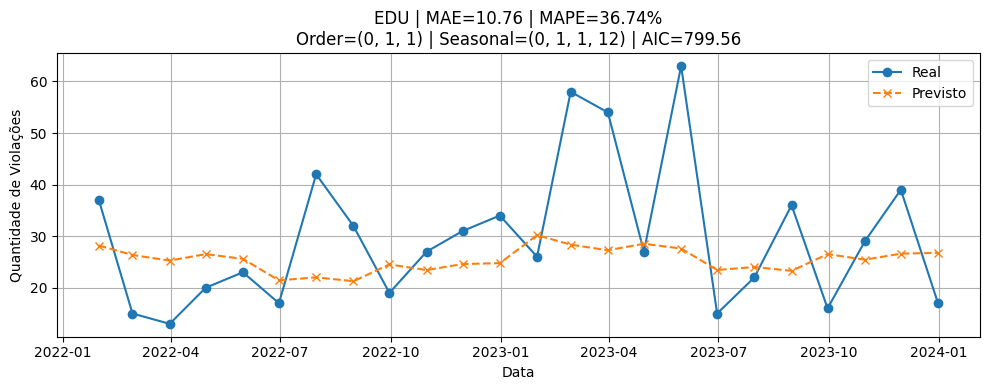


🚩 Iniciando ARIMA para: GOV

📊 Resultados para GOV
MAE:  4.19
RMSE: 5.48
MAPE: 43.29%
Melhores parâmetros: Order=(1, 1, 1) | Seasonal=(1, 1, 1, 12) | AIC=635.05


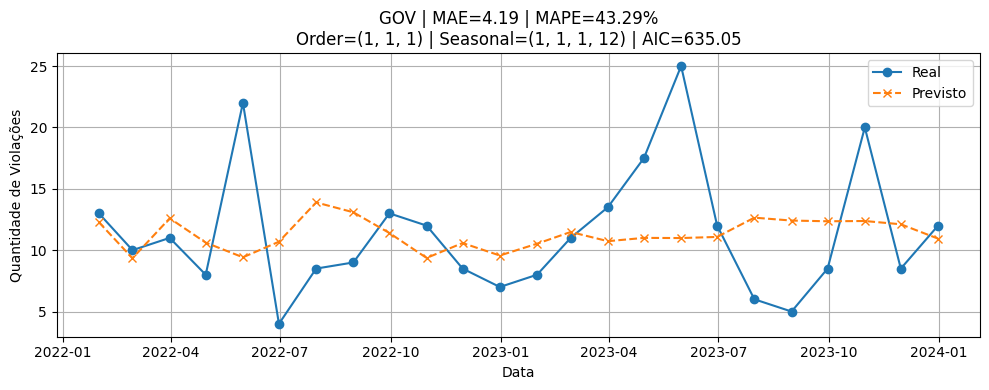


🚩 Iniciando ARIMA para: MED

📊 Resultados para MED
MAE:  17.47
RMSE: 19.64
MAPE: 32.19%
Melhores parâmetros: Order=(1, 1, 1) | Seasonal=(0, 1, 1, 12) | AIC=907.35


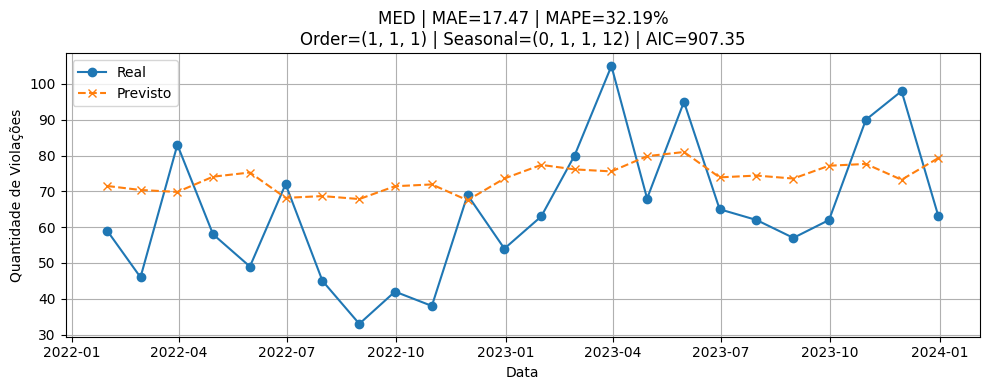


🚩 Iniciando ARIMA para: NGO

📊 Resultados para NGO
MAE:  5.72
RMSE: 6.65
MAPE: 53.56%
Melhores parâmetros: Order=(1, 1, 1) | Seasonal=(0, 1, 1, 12) | AIC=650.87


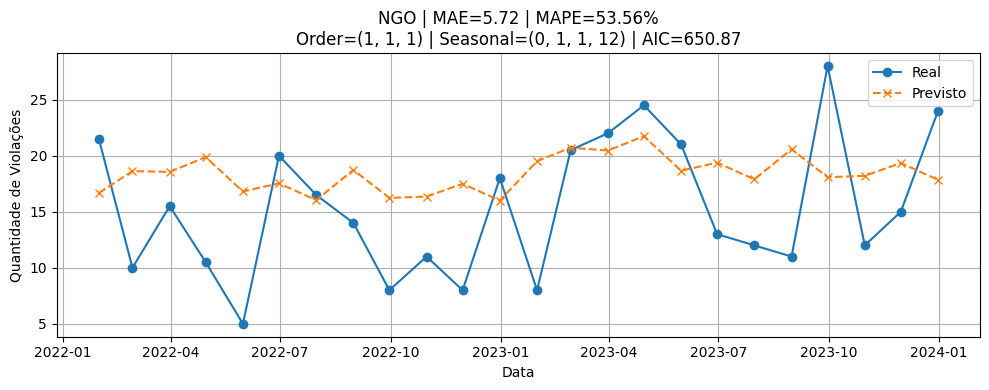


🚩 Iniciando ARIMA para: Total Geral

📊 Resultados para Total Geral
MAE:  93.98
RMSE: 104.40
MAPE: 27.61%
Melhores parâmetros: Order=(1, 1, 1) | Seasonal=(0, 1, 1, 12) | AIC=1200.00


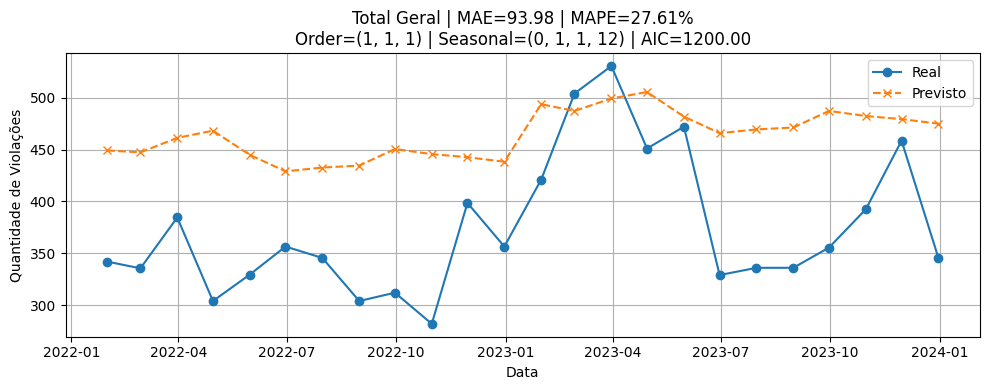


🚩 Iniciando ARIMA para: UNKN

📊 Resultados para UNKN
MAE:  31.58
RMSE: 35.08
MAPE: 32.76%
Melhores parâmetros: Order=(1, 1, 1) | Seasonal=(0, 1, 1, 12) | AIC=1015.65


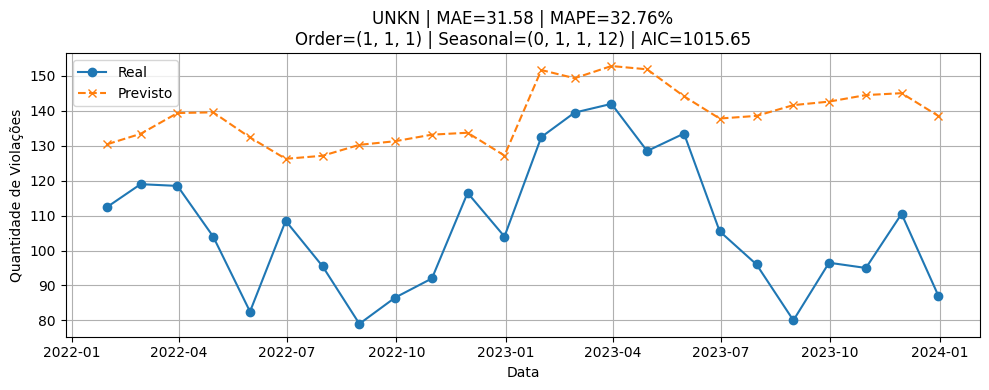


✅ Resultados Consolidados:
        Coluna      Order Seasonal_Order      AIC    MAE    RMSE  MAPE%  \
0          BSF  (0, 1, 1)  (0, 1, 1, 12)   824.61  18.84   20.99  55.43   
1          BSO  (0, 1, 1)  (0, 1, 1, 12)   906.69  25.12   27.89  34.77   
2          BSR  (0, 1, 1)  (0, 1, 1, 12)   836.44   7.52    9.35  80.64   
3          EDU  (0, 1, 1)  (0, 1, 1, 12)   799.56  10.76   13.82  36.74   
4          GOV  (1, 1, 1)  (1, 1, 1, 12)   635.05   4.19    5.48  43.29   
5          MED  (1, 1, 1)  (0, 1, 1, 12)   907.35  17.47   19.64  32.19   
6          NGO  (1, 1, 1)  (0, 1, 1, 12)   650.87   5.72    6.65  53.56   
7  Total Geral  (1, 1, 1)  (0, 1, 1, 12)  1200.00  93.98  104.40  27.61   
8         UNKN  (1, 1, 1)  (0, 1, 1, 12)  1015.65  31.58   35.08  32.76   

    Status  
0  Sucesso  
1  Sucesso  
2  Sucesso  
3  Sucesso  
4  Sucesso  
5  Sucesso  
6  Sucesso  
7  Sucesso  
8  Sucesso  

💾 Resultados salvos em 'resultados_arima_gridsearch.csv'


In [17]:
# ==========================================
# 📦 Importações
# ==========================================
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error


# ==========================================
# ⚙️ Definição dos Parâmetros do Grid Search
# ==========================================
# Parâmetros ARIMA (não sazonais)
p = d = q = range(0, 2)

# Parâmetros sazonais SARIMA
P = D = Q = range(0, 2)
s = 12  # Sazonalidade mensal (12 meses)

# Combinações de parâmetros
param_combinations = list(itertools.product(p, d, q))
seasonal_combinations = list(itertools.product(P, D, Q))


# ==========================================
# 📂 Lista para armazenar resultados
# ==========================================
resultados_arima = []


# ==========================================
# 🔹 Função para aplicar ARIMA em uma série
# ==========================================
def aplicar_arima_serie(nome_coluna, df_series):
    """
    Ajusta um modelo SARIMA para a série temporal de cada coluna.
    - Divide dados em treino e teste (últimos 24 meses)
    - Faz grid search para encontrar melhores parâmetros (menor AIC)
    - Calcula métricas (MAE, RMSE, MAPE)
    - Plota gráfico comparando valores reais e previstos
    - Armazena os resultados na lista global
    """
    print(f"\n🚩 Iniciando ARIMA para: {nome_coluna}")

    # Seleciona a série
    serie = df_series[nome_coluna].dropna()

    # Verifica se a série tem dados relevantes
    if serie.sum() == 0:
        print(f"⚠️ Série {nome_coluna} sem dados relevantes. Pulando...")
        return

    # Divide em treino e teste (últimos 24 meses para teste)
    train = serie[:-24]
    test = serie[-24:]

    best_aic = np.inf
    best_model = None
    best_params = None

    # ==========================================
    # 🔎 Grid Search
    # ==========================================
    for param in param_combinations:
        for seasonal_param in seasonal_combinations:
            try:
                model = SARIMAX(
                    train,
                    order=param,
                    seasonal_order=seasonal_param + (s,),
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                fit = model.fit(disp=False)

                if fit.aic < best_aic:
                    best_aic = fit.aic
                    best_model = fit
                    best_params = (param, seasonal_param + (s,))
            except Exception:
                continue

    # ==========================================
    # 🔎 Verifica se encontrou algum modelo
    # ==========================================
    if best_model is None:
        print(f"⚠️ Nenhum modelo válido para {nome_coluna}. Registrando falha.")
        resultados_arima.append({
            'Coluna': nome_coluna,
            'Order': None,
            'Seasonal_Order': None,
            'AIC': None,
            'MAE': None,
            'RMSE': None,
            'MAPE%': None,
            'Status': 'Erro no ajuste'
        })
        return

    # ==========================================
    # ✅ Forecast com o melhor modelo
    # ==========================================
    try:
        forecast = best_model.forecast(steps=24)
        forecast.index = test.index

        # Calcula métricas de avaliação
        mae = mean_absolute_error(test, forecast)
        rmse = np.sqrt(mean_squared_error(test, forecast))

        # Evita divisão por zero no cálculo do MAPE
        mask = test != 0
        mape = (
            np.mean(np.abs((test[mask] - forecast[mask]) / test[mask])) * 100
            if mask.sum() > 0 else None
        )

        # Exibe resultados
        print(f"\n📊 Resultados para {nome_coluna}")
        print(f"MAE:  {mae:.2f}")
        print(f"RMSE: {rmse:.2f}")
        print(f"MAPE: {mape:.2f}%")
        print(f"Melhores parâmetros: Order={best_params[0]} | Seasonal={best_params[1]} | AIC={best_aic:.2f}")

        # ==========================================
        # 📈 Gráfico Real vs Previsto
        # ==========================================
        plt.figure(figsize=(10, 4))
        plt.plot(test, label='Real', marker='o')
        plt.plot(forecast, label='Previsto', marker='x', linestyle='--')
        plt.title(f"{nome_coluna} | MAE={mae:.2f} | MAPE={mape:.2f}%\n"
                  f"Order={best_params[0]} | Seasonal={best_params[1]} | AIC={best_aic:.2f}")
        plt.xlabel('Data')
        plt.ylabel('Quantidade de Violações')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Armazena resultados
        resultados_arima.append({
            'Coluna': nome_coluna,
            'Order': best_params[0],
            'Seasonal_Order': best_params[1],
            'AIC': round(best_aic, 2),
            'MAE': round(mae, 2),
            'RMSE': round(rmse, 2),
            'MAPE%': round(mape, 2) if mape is not None else None,
            'Status': 'Sucesso'
        })

    except Exception as e:
        print(f"⚠️ Erro ao prever {nome_coluna}: {e}")
        resultados_arima.append({
            'Coluna': nome_coluna,
            'Order': best_params[0],
            'Seasonal_Order': best_params[1],
            'AIC': round(best_aic, 2),
            'MAE': None,
            'RMSE': None,
            'MAPE%': None,
            'Status': 'Erro na previsão'
        })


# ==========================================
# 🚀 Aplicar ARIMA em todas as colunas
# ==========================================
for col in df_filtered.columns:
    if df_filtered[col].sum() > 0:
        aplicar_arima_serie(col, df_filtered)


# ==========================================
# 💾 Consolidar e Exportar Resultados
# ==========================================
df_resultados_arima = pd.DataFrame(resultados_arima)

# Exibe a tabela de resultados
print("\n✅ Resultados Consolidados:")
print(df_resultados_arima)

# Salva em CSV
df_resultados_arima.to_csv('resultados_arima_gridsearch.csv', index=False)
print("\n💾 Resultados salvos em 'resultados_arima_gridsearch.csv'")



🚩 Iniciando XGBoost para: BSF

📊 Resultados para BSF
MAE:  7.40
RMSE: 9.39
MAPE: 19.96%
Melhores parâmetros: {'n_estimators': 50, 'learning_rate': 0.05, 'max_depth': 5}


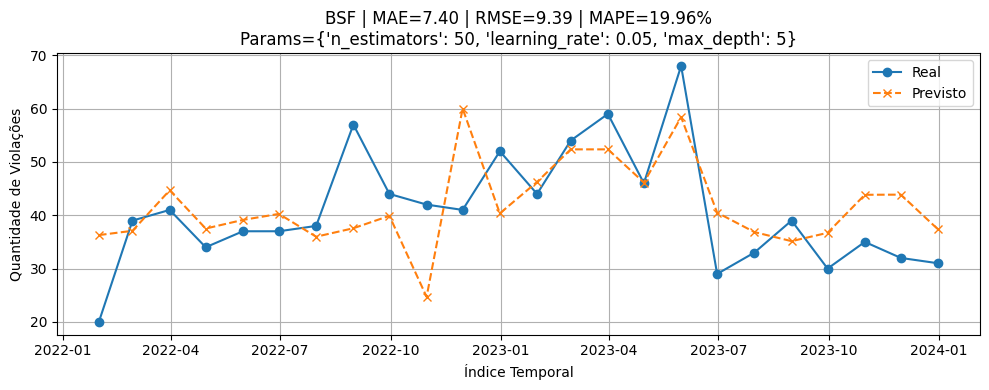


🚩 Iniciando XGBoost para: BSO

📊 Resultados para BSO
MAE:  9.53
RMSE: 13.06
MAPE: 11.40%
Melhores parâmetros: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3}


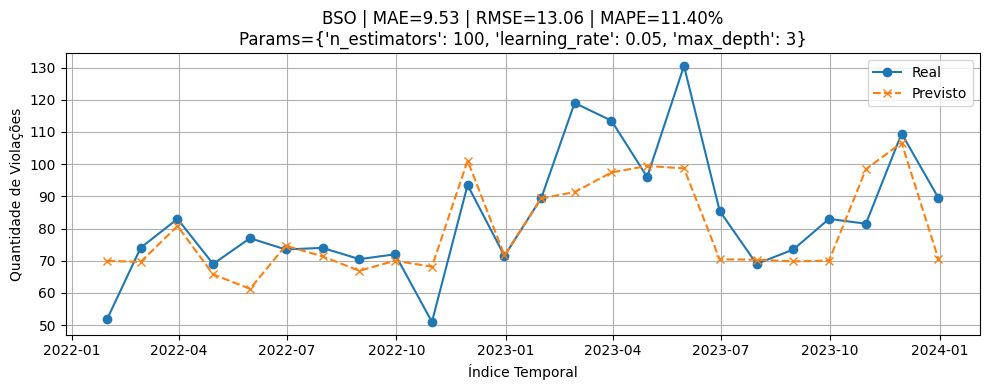


🚩 Iniciando XGBoost para: BSR

📊 Resultados para BSR
MAE:  7.33
RMSE: 9.30
MAPE: 83.34%
Melhores parâmetros: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3}


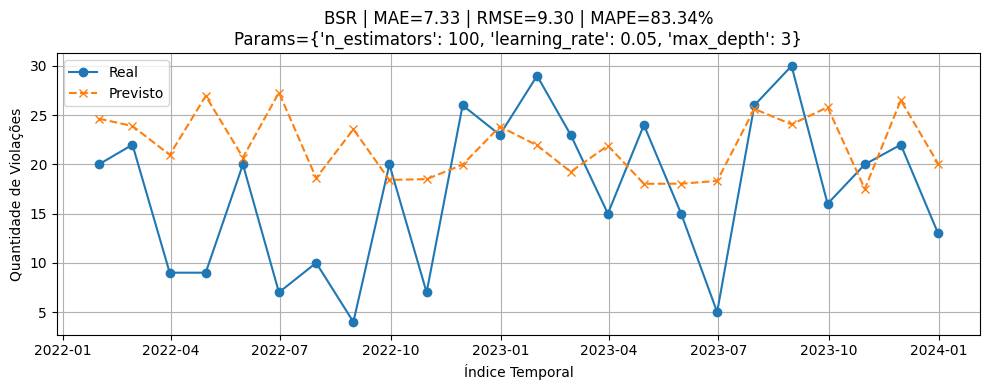


🚩 Iniciando XGBoost para: EDU

📊 Resultados para EDU
MAE:  12.23
RMSE: 16.20
MAPE: 36.78%
Melhores parâmetros: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3}


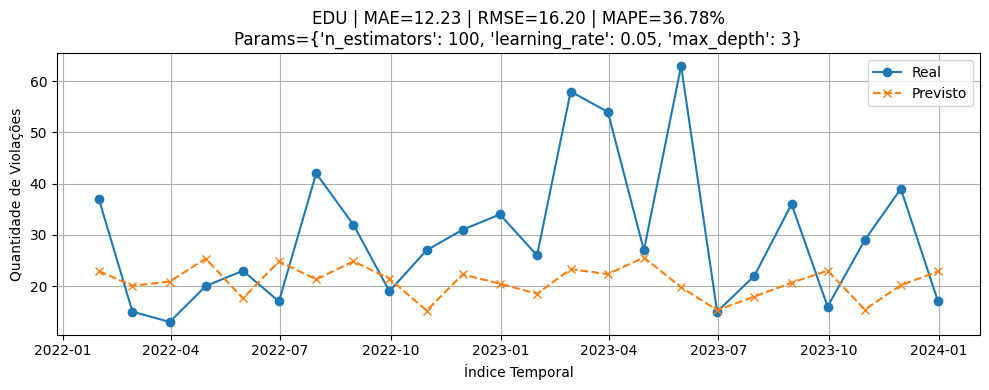


🚩 Iniciando XGBoost para: GOV

📊 Resultados para GOV
MAE:  4.01
RMSE: 5.71
MAPE: 35.68%
Melhores parâmetros: {'n_estimators': 100, 'learning_rate': 0.05, 'max_depth': 3}


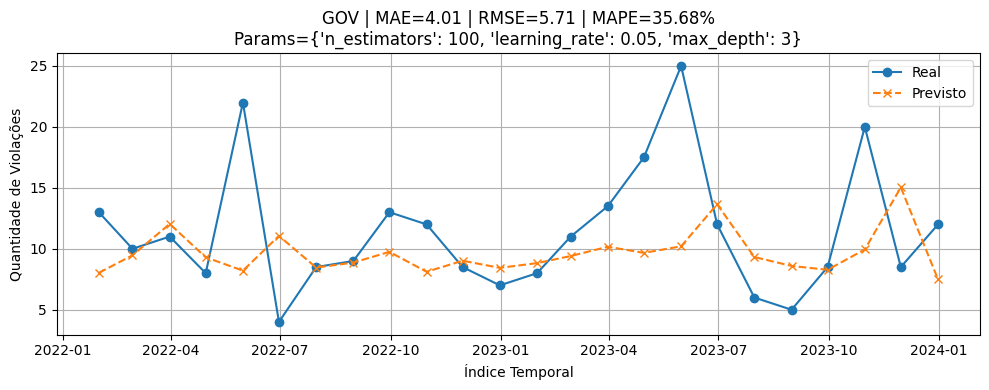


🚩 Iniciando XGBoost para: MED

📊 Resultados para MED
MAE:  12.64
RMSE: 15.41
MAPE: 21.53%
Melhores parâmetros: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3}


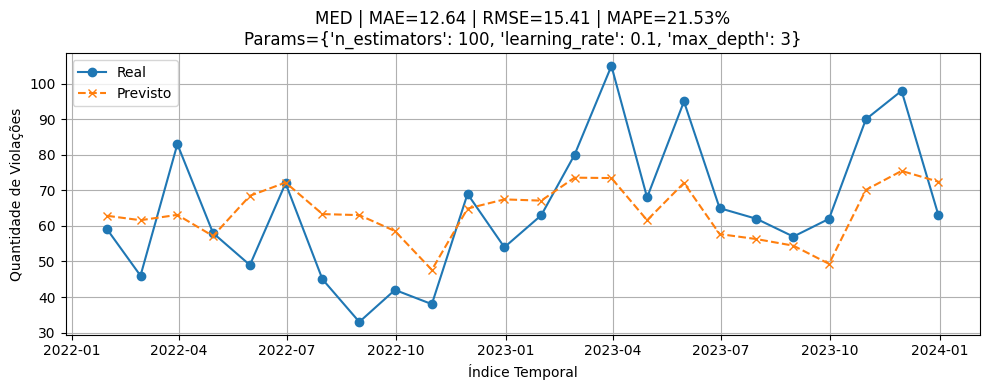


🚩 Iniciando XGBoost para: NGO

📊 Resultados para NGO
MAE:  5.35
RMSE: 6.65
MAPE: 42.21%
Melhores parâmetros: {'n_estimators': 50, 'learning_rate': 0.05, 'max_depth': 3}


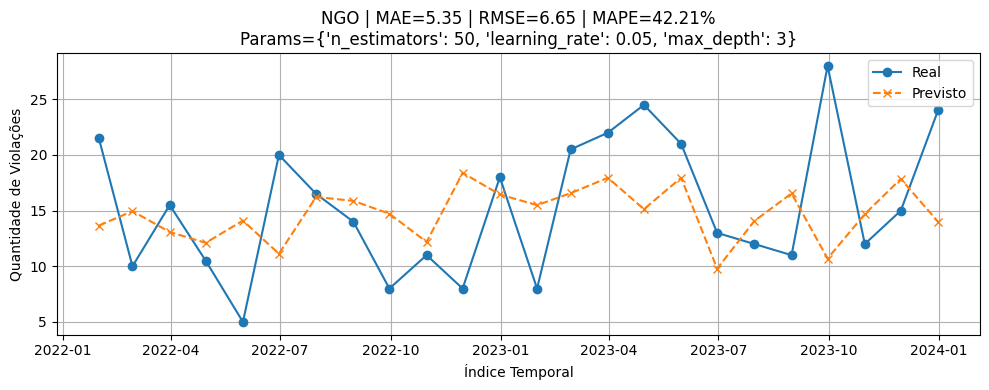


🚩 Iniciando XGBoost para: Total Geral

📊 Resultados para Total Geral
MAE:  23.74
RMSE: 32.80
MAPE: 5.97%
Melhores parâmetros: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 3}


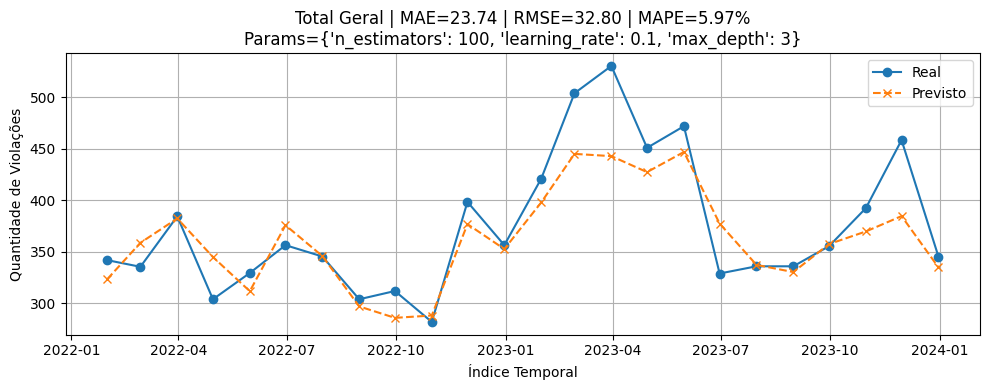


🚩 Iniciando XGBoost para: UNKN

📊 Resultados para UNKN
MAE:  10.07
RMSE: 12.57
MAPE: 10.03%
Melhores parâmetros: {'n_estimators': 50, 'learning_rate': 0.05, 'max_depth': 3}


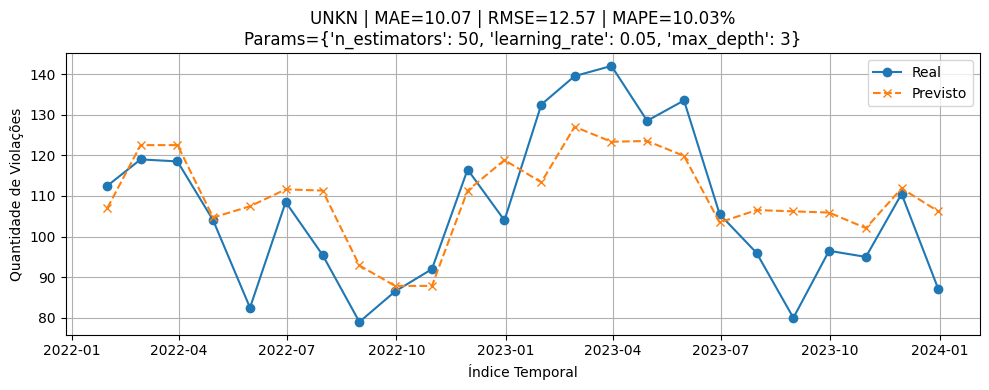


✅ Melhores modelos por série:
        Coluna    MAE   RMSE  MAPE%  \
0          BSF   7.40   9.39  19.96   
1          BSO   9.53  13.06  11.40   
2          BSR   7.33   9.30  83.34   
3          EDU  12.23  16.20  36.78   
4          GOV   4.01   5.71  35.68   
5          MED  12.64  15.41  21.53   
6          NGO   5.35   6.65  42.21   
7  Total Geral  23.74  32.80   5.97   
8         UNKN  10.07  12.57  10.03   

                                         Best Params   Status  
0  {'n_estimators': 50, 'learning_rate': 0.05, 'm...  Sucesso  
1  {'n_estimators': 100, 'learning_rate': 0.05, '...  Sucesso  
2  {'n_estimators': 100, 'learning_rate': 0.05, '...  Sucesso  
3  {'n_estimators': 100, 'learning_rate': 0.05, '...  Sucesso  
4  {'n_estimators': 100, 'learning_rate': 0.05, '...  Sucesso  
5  {'n_estimators': 100, 'learning_rate': 0.1, 'm...  Sucesso  
6  {'n_estimators': 50, 'learning_rate': 0.05, 'm...  Sucesso  
7  {'n_estimators': 100, 'learning_rate': 0.1, 'm...  Sucesso  
8 

In [18]:
# ==========================================
# 📦 Importações
# ==========================================
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

# ==========================================
# ⚙️ Função para criar features defasadas
# ==========================================
def create_features(df, target_col, lags=12):
    """
    Cria colunas defasadas (lags) para a série temporal.
    Isso permite ao modelo XGBoost aprender padrões temporais.
    """
    df_feat = df.copy()
    for lag in range(1, lags + 1):
        df_feat[f'{target_col}_lag{lag}'] = df_feat[target_col].shift(lag)
    df_feat = df_feat.dropna()
    return df_feat

# ==========================================
# ⚙️ Definição dos Hiperparâmetros para Grid Search
# ==========================================
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}
grid_combinations = list(itertools.product(*param_grid.values()))

# ==========================================
# 📂 Listas para armazenar resultados
# ==========================================
resultados_xgb = []             # Melhores modelos por coluna
grid_search_resultados = []     # Todos os resultados do grid

# ==========================================
# 🚀 Aplicar XGBoost para cada série
# ==========================================
for col in df_filtered.columns:
    print(f"\n🚩 Iniciando XGBoost para: {col}")

    # Criar features defasadas
    df_feat = create_features(df_filtered, col, lags=12)

    # Verifica se há dados suficientes
    if df_feat.empty or df_feat[col].sum() == 0:
        print(f"⚠️ Série {col} sem dados relevantes. Pulando...")
        continue

    # Divide em treino e teste (últimos 24 períodos para teste)
    X = df_feat.drop(columns=[col])
    y = df_feat[col]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, shuffle=False, test_size=24
    )

    best_model = None
    best_rmse = np.inf
    best_params = None
    best_y_pred = None

    # ==========================================
    # 🔎 Grid Search Manual
    # ==========================================
    for params in grid_combinations:
        param_dict = dict(zip(param_grid.keys(), params))
        try:
            # Ajuste do modelo
            model = XGBRegressor(random_state=42, **param_dict)
            model.fit(X_train, y_train)

            # Previsão
            y_pred = model.predict(X_test)

            # Métricas
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mape = (
                np.mean(np.abs((y_test - y_pred) / y_test.replace(0, np.nan))) * 100
            )

            # Armazena resultados do grid
            grid_search_resultados.append({
                'Coluna': col,
                'n_estimators': param_dict['n_estimators'],
                'learning_rate': param_dict['learning_rate'],
                'max_depth': param_dict['max_depth'],
                'MAE': round(mae, 2),
                'RMSE': round(rmse, 2),
                'MAPE%': round(mape, 2) if not np.isnan(mape) else 'N/A'
            })

            # Atualiza melhor modelo
            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model
                best_params = param_dict
                best_y_pred = y_pred

        except Exception as e:
            print(f"⚠️ Erro ao ajustar modelo para {col} com params {param_dict}: {e}")
            continue

    # ==========================================
    # ✅ Melhor modelo encontrado
    # ==========================================
    if best_model is None:
        print(f"⚠️ Nenhum modelo válido para {col}. Registrando falha.")
        resultados_xgb.append({
            'Coluna': col,
            'MAE': None,
            'RMSE': None,
            'MAPE%': None,
            'Best Params': None,
            'Status': 'Erro no ajuste'
        })
        continue

    mae = mean_absolute_error(y_test, best_y_pred)
    mape = (
        np.mean(np.abs((y_test - best_y_pred) / y_test.replace(0, np.nan))) * 100
    )

    print(f"\n📊 Resultados para {col}")
    print(f"MAE:  {mae:.2f}")
    print(f"RMSE: {best_rmse:.2f}")
    print(f"MAPE: {mape:.2f}%")
    print(f"Melhores parâmetros: {best_params}")

    # Gráfico Real vs Previsto
    plt.figure(figsize=(10, 4))
    plt.plot(y_test.index, y_test.values, label='Real', marker='o')
    plt.plot(y_test.index, best_y_pred, label='Previsto', marker='x', linestyle='--')
    plt.title(f"{col} | MAE={mae:.2f} | RMSE={best_rmse:.2f} | MAPE={mape:.2f}%\nParams={best_params}")
    plt.xlabel('Índice Temporal')
    plt.ylabel('Quantidade de Violações')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Armazena resultados do melhor modelo
    resultados_xgb.append({
        'Coluna': col,
        'MAE': round(mae, 2),
        'RMSE': round(best_rmse, 2),
        'MAPE%': round(mape, 2) if not np.isnan(mape) else 'N/A',
        'Best Params': best_params,
        'Status': 'Sucesso'
    })

# ==========================================
# 💾 Consolidar e Exportar Resultados
# ==========================================
df_resultados_xgb = pd.DataFrame(resultados_xgb)
df_gridsearch_xgb = pd.DataFrame(grid_search_resultados)

# Exibe resumo
print("\n✅ Melhores modelos por série:")
print(df_resultados_xgb)

# Salva em CSV
df_resultados_xgb.to_csv('melhores_resultados_xgboost.csv', index=False)
df_gridsearch_xgb.to_csv('gridsearch_completo_xgboost.csv', index=False)

print("\n💾 Resultados salvos em:")
print("  - melhores_resultados_xgboost.csv")
print("  - gridsearch_completo_xgboost.csv")


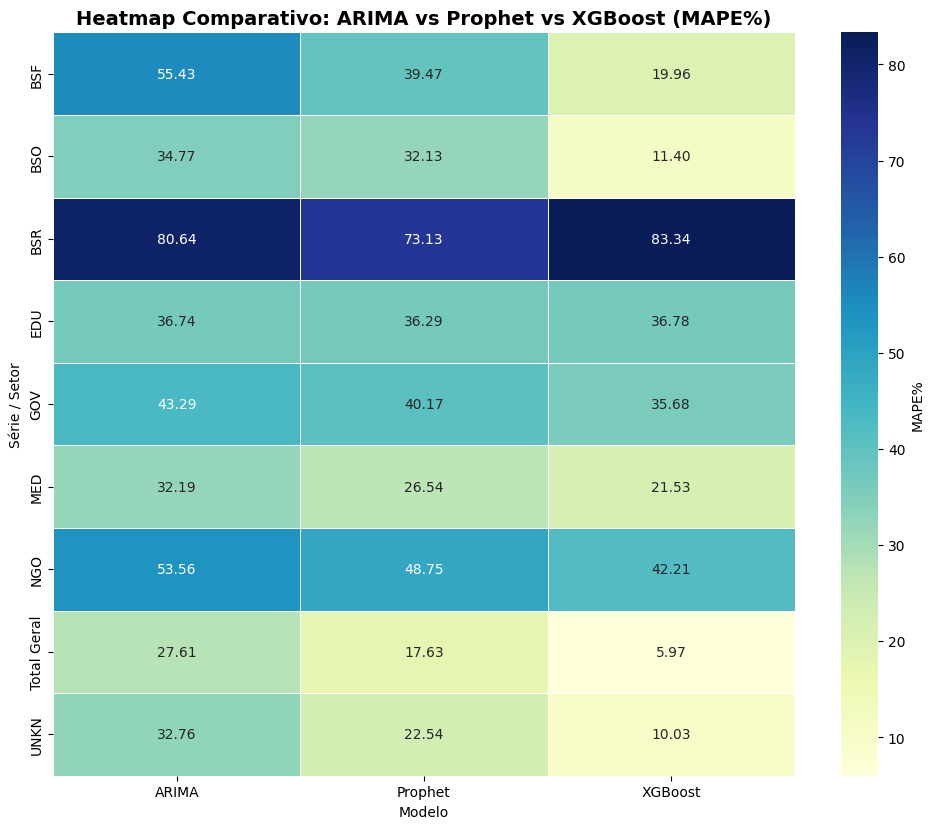

In [19]:
# ==========================================
# 📦 Importações
# ==========================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 📂 Carregar resultados dos modelos
# ==========================================
df_arima = pd.read_csv('resultados_arima_gridsearch.csv')
df_prophet = pd.read_csv('resultados_prophet_gridsearch.csv')
df_xgb = pd.read_csv('melhores_resultados_xgboost.csv')

# Padroniza nomes das colunas
df_arima = df_arima.rename(columns={'Coluna': 'Serie'})
df_prophet = df_prophet.rename(columns={'Coluna': 'Serie'})
df_xgb = df_xgb.rename(columns={'Coluna': 'Serie', 'MAPE (%)': 'MAPE%'})

# 🔧 Se não existir 'MAPE%' no Prophet, renomeia automaticamente
if 'MAPE' in df_prophet.columns and 'MAPE%' not in df_prophet.columns:
    df_prophet = df_prophet.rename(columns={'MAPE': 'MAPE%'})

# ==========================================
# 🔎 Selecionar apenas MAPE%
# ==========================================
def selecionar_mape(df, nome_modelo):
    if 'MAPE%' not in df.columns:
        raise ValueError(f"O DataFrame do modelo {nome_modelo} não possui a coluna 'MAPE%'.")
    df_sel = df[['Serie', 'MAPE%']].copy()
    df_sel['Modelo'] = nome_modelo
    return df_sel

df_arima_mape = selecionar_mape(df_arima, 'ARIMA')
df_prophet_mape = selecionar_mape(df_prophet, 'Prophet')
df_xgb_mape = selecionar_mape(df_xgb, 'XGBoost')

# ==========================================
# 🔗 Concatenar resultados
# ==========================================
df_comparacao = pd.concat(
    [df_arima_mape, df_prophet_mape, df_xgb_mape],
    ignore_index=True
)

# Converte MAPE% para numérico
df_comparacao['MAPE%'] = pd.to_numeric(df_comparacao['MAPE%'], errors='coerce')

# ==========================================
# 🔄 Reestruturar dados para Heatmap
# ==========================================
df_heatmap = df_comparacao.pivot_table(
    index='Serie',
    columns='Modelo',
    values='MAPE%'
)

# ==========================================
# 🎨 Plotar Heatmap (somente MAPE%)
# ==========================================
plt.figure(figsize=(10, len(df_heatmap) * 0.6 + 3))
sns.heatmap(
    df_heatmap,
    annot=True,
    fmt=".2f",
    cmap='YlGnBu',
    linewidths=0.5,
    cbar_kws={'label': 'MAPE%'}
)

plt.title('Heatmap Comparativo: ARIMA vs Prophet vs XGBoost (MAPE%)',
          fontsize=14,
          weight='bold')
plt.xlabel('Modelo')
plt.ylabel('Série / Setor')
plt.tight_layout()
plt.show()
